# **Extended Kalman Filter Implementation**


## 0. Parameters selection

For explenations and experiments see --> "Parameters_for_kalman_experiments.ipynb" :

In [2]:
import numpy as np

#PARAMETERS

#Conversion coefficients from Thymio to radians per second
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137

#Conversion function from wheels angular velocity in in rad/s to linear and angular velocity of the robot respectively in mm/s and rad/s
def convert_velocity(motor_right_speed, motor_left_speed,C_conv_toThymio_right, C_conv_toThymio_left, L, R):
    vr_rads= motor_right_speed/C_conv_toThymio_right
    vl_rads= motor_left_speed/C_conv_toThymio_left
    v=R* (vr_rads+vl_rads)/2   
    w=R*(vr_rads-vl_rads)/L
    return v, w

#Covariance matrix of the proccess noise
Q = np.array([[0.03750, 0, 0],[0 ,0.03750, 0], [0, 0, 0.00001]])

#Covariance matrix of the measurement noise
R= np.array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.01]]) #TO BE CHANGED AFTER MEASUREMENTS

#Thymio parameters:
R = 20 #mm
L = 104 #mm

# 1. Kalman Filter state space model

main source used: https://automaticaddison.com/how-to-derive-the-state-space-model-for-a-mobile-robot/

A state space model, also known as a state transition model, is a formula that describes how a robot moves from one point in time to the next. It illustrates the way a robot's location (such as its X and Y coordinates) and its direction (or yaw, represented by the angle $theta$) are influenced by adjustments to its control inputs.

We chosed to use $\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ as the state vector for our differential drive robot. This are infact the quantities that the camera will be able to give us. The vectors refer to the global fixed reference and $theta$ is the angle with the positive direction of the x-axis. Since the only input is the velocity of the two wheels, the systems evolves accordingly to the following equatrions:

$$
\begin{bmatrix}
x_t \\
y_t \\
\theta_t
\end{bmatrix}
=
\begin{bmatrix}
x_{t-1} + v_{t-1} \cos \theta_{t-1} * Ts \\
y_{t-1} + v_{t-1} \sin \theta_{t-1} * Ts \\
\theta_{t-1} + \omega_{t-1} * Ts
\end{bmatrix}
=
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
$$
The inputs considered are the ones taht we use to control it: $v$ and $\omega$, respectvely linear and angular velocity of the robot. The linear velociy has as direction the one indicated by the angle $\theta$. The controller will use hese quantities to execute the path following.
We then linearize in order to obtain a linearized state space model:

$$
A_{t-1} =
\begin{bmatrix}
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_1}{\partial y_{t-1}} & \frac{\partial f_1}{\partial \theta_{t-1}} \\
\frac{\partial f_2}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}} & \frac{\partial f_2}{\partial \theta_{t-1}} \\
\frac{\partial f_3}{\partial x_{t-1}} & \frac{\partial f_3}{\partial y_{t-1}} & \frac{\partial f_3}{\partial \theta_{t-1}}
\end{bmatrix}
$$


Matrix A relates the states of two consecutive sample is consequently an identity of the same dimension as the state. This is also the result of the above calculations since every function f_i depends linearly and with an unitary coefficient from the corrispondent variable:
$$ A = \begin{bmatrix} 1& 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

Same thing we did about B matrix considering three partial derivatives with respect to velocity and angular velocity:

$$
B_{t-1} =
\begin{bmatrix}
\frac{\partial f_1}{\partial v_{t-1}} & \frac{\partial f_1}{\partial \omega_{t-1}} \\
\frac{\partial f_2}{\partial v_{t-1}} & \frac{\partial f_2}{\partial \omega_{t-1}} \\
\frac{\partial f_3}{\partial v_{t-1}} & \frac{\partial f_3}{\partial \omega_{t-1}}
\end{bmatrix}
$$


and so:

$$
B_{t-1} =
\begin{bmatrix}
\cos \theta_{t-1} * Ts & 0 \\
\sin \theta_{t-1} * Ts & 0 \\
0 & dt
\end{bmatrix}
$$

Finally, we added a process noise w with a Gaussian distribution with zero mean and covariance Q:
$$
\begin{bmatrix}
x_t \\
y_t \\
\theta_t
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
\cos \gamma_{t-1} * Ts & 0 \\
\sin \gamma_{t-1} * Ts & 0 \\
0 & dt
\end{bmatrix}
\begin{bmatrix}
v_{t-1} \\
\omega_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
w_{x_{t-1}} \\
w_{y_{t-1}} \\
w_{\theta_{t-1}}
\end{bmatrix}
$$


# 2. Kalman Filter observation model
The observation model consists in predicting sensor measurements based on the estimated or predicted state of the system at the next timestep. Instead of directly translating raw sensor data into a state estimate, this model uses the current state prediction to forecast what the sensors should detect, creating a basis for comparison with actual sensor readings.
The observation model works by first using the state model to predict the state of the robot at that next timestep and then using that state prediction to infer what the sensor measurement would be at that point in time. 
This allows to then compute a weighted average (Kalman Filtering) of the predicted sensor measurements and the actual sensor observation at that timestep to create a better estimate of your state.

The measurements we obtain are the ones coming from the camera: position in terms of (x,y) coordinates and orientation ($\theta$ angle).
The general equation for the observation model is the following:
$$
y_t = H\cdot
\begin{bmatrix}
x\\
y\\
\theta
\end{bmatrix}
+
\begin{bmatrix}
v_{x_{t-1}} \\
v_{y_{t-1}} \\
v_{\theta_{t-1}}
\end{bmatrix}
$$

v is the measurement noise gaussianly distributed with zero mean and covariance matrix R.
The measurement matrix H is used to convert the predicted state estimate at time t into predicted sensor measurements at time t. In our case, H will be the identity matrix since the estimated state maps directly to sensor measurements [x, y, $\theta$]:
$$
H = 
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}


# 3. Kalman Filter actual implementation
code derived from: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/ 

In [11]:
import matplotlib.pyplot as plt

# Extended Kalman Filter Code

# A matrix
A_k_minus_1 = np.array([[1.0, 0, 0],
                        [0, 1.0, 0],
                        [0, 0, 1.0]])

# Process noise
process_noise_v_k_minus_1 = np.array([0.01, 0.01, 0.003]) #

# State model noise covariance matrix Q_k
Q_k = np.array([[0.13661, 0, 0],
              [0 ,0.13661, 0],
              [0, 0, 0.00005]])

# Measurement matrix H_k
H_k = np.array([[1.0, 0, 0],
                [0, 1.0, 0],
                [0, 0, 1.0]])

# Sensor measurement noise covariance matrix R_k
R_k= np.array([[0.01, 0, 0],
               [0, 0.01, 0],
               [0, 0, 0.00001]]) #TO BE CHANGED AFTER MEASUREMENTS

# Sensor noise
sensor_noise_w_k = np.array([0, 0, 0]) #zero mean noise

# Function to get B matrix
def getB(yaw, deltak):
    B = np.array([[np.cos(yaw) * deltak, 0],
                  [np.sin(yaw) * deltak, 0],
                  [0, deltak]])
    return B

# Extended Kalman Filter function with a priori state output
def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk):
    # PREDICT
    
    state_estimate_k_priori = A_k_minus_1 @ state_estimate_k_minus_1 + \
                              getB(state_estimate_k_minus_1[2], dk) @ control_vector_k_minus_1 + \
                              process_noise_v_k_minus_1
             
    # Predict state covariance
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + Q_k
         
    # MEASUREMENT residual
    measurement_residual_y_k = z_k_observation_vector - (H_k @ state_estimate_k_priori + sensor_noise_w_k)
             
    # Measurement residual covariance
    S_k = H_k @ P_k @ H_k.T + R_k
         
    # Kalman gain
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
         
    # UPDATE state estimate
    state_estimate_k = state_estimate_k_priori + (K_k @ measurement_residual_y_k)
     
    # Update state covariance
    P_k = P_k - (K_k @ H_k @ P_k)
     
    return state_estimate_k_priori, state_estimate_k, P_k

Measurement: [4.721 0.143 0.006]
State estimate: [5.06888516 0.13760687 0.00599974]
Measurement: [9.353e+00 2.840e-01 7.000e-03]
State estimate: [9.93018195e+00 2.80372968e-01 7.34509225e-03]
Measurement: [1.4773e+01 4.2200e-01 9.0000e-03]
State estimate: [1.53152215e+01 4.19819437e-01 9.25680700e-03]
Measurement: [1.8246e+01 5.5500e-01 1.1000e-02]
State estimate: [1.89108025e+01 5.54861668e-01 1.12440379e-02]
Measurement: [2.2609e+01 7.1500e-01 1.2000e-02]
State estimate: [2.32245818e+01 7.14954734e-01 1.23880752e-02]


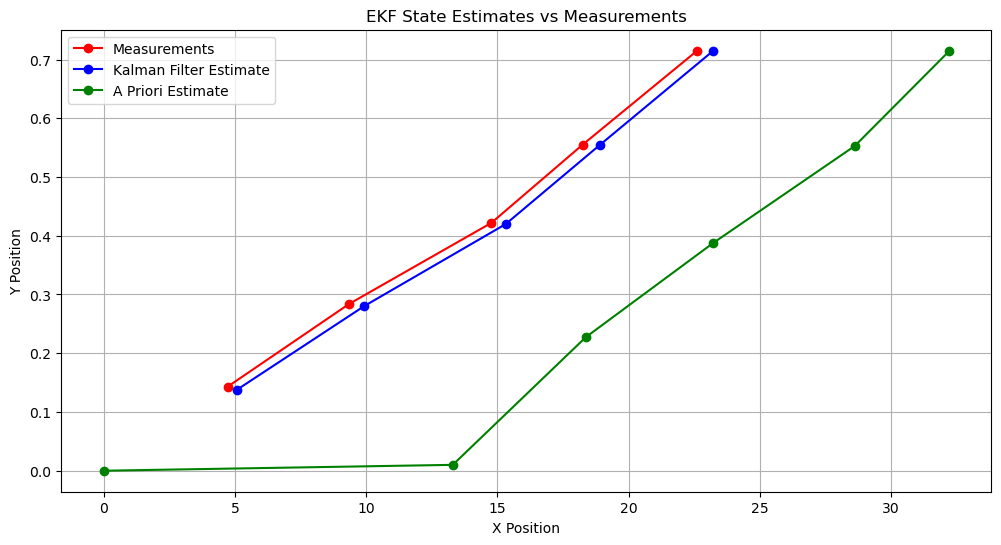

In [13]:
# Main function with modifications
def main():
    # Time interval in seconds
    dk = 1

    # Sensor observations
    z_k = np.array([[4.721, 0.143, 0.006], # k=1
                    [9.353, 0.284, 0.007], # k=2
                    [14.773, 0.422, 0.009],# k=3
                    [18.246, 0.555, 0.011], # k=4
                    [22.609, 0.715, 0.012]])# k=5

    # Initial state estimate
    state_estimate_k_minus_1 = np.array([0.0, 0.0, 0.0])

    # Control vector
    vr= 45
    vl= 45
    control_vector_k_minus_1 =convert_velocity(vr, vl, C_conv_toThymio_right, C_conv_toThymio_left, L, R)

    # Initial state covariance matrix
    P_k_minus_1 = np.array([[0.1, 0, 0],
                            [0, 0.1, 0],
                            [0, 0, 0.1]])

    # Lists to store states
    priori_estimates = [state_estimate_k_minus_1]
    estimated_states = []
    measurements = []

    # Run EKF for each observation
    for obs_vector_z_k in z_k:
        priori_estimate_k, optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, state_estimate_k_minus_1, control_vector_k_minus_1, P_k_minus_1, dk)

        priori_estimates.append(priori_estimate_k)
        estimated_states.append(optimal_state_estimate_k)
        measurements.append(obs_vector_z_k)
        print('Measurement:', obs_vector_z_k)

        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k

        print('State estimate:', optimal_state_estimate_k)

    return np.array(priori_estimates), np.array(estimated_states), np.array(measurements)

# Run main function and plot results


# Run main function and plot results
priori_estimates, estimated_states, measurements = main()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(measurements[:, 0], measurements[:, 1], 'ro-', label='Measurements')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], 'bo-', label='Kalman Filter Estimate')
plt.plot(priori_estimates[:, 0], priori_estimates[:, 1], 'go-', label='A Priori Estimate') # new line for a priori estimates
plt.title('EKF State Estimates vs Measurements')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()